In [23]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [24]:
data1 = np.load("mu_0.9.npy")
data2 = np.load("mu_0.95.npy")
data3 = np.load("mu_1.05.npy")
data4 = np.load("mu_1.1.npy")

dt = 2 / 1500

data1_dot = (data1[1:] - data1[:-1]) / dt
data1 = data1[1:]

data2_dot = (data2[1:] - data2[:-1]) / dt
data2 = data2[1:]

data3_dot = (data3[1:] - data3[:-1]) / dt
data3 = data3[1:]

data4_dot = (data4[1:] - data4[:-1]) / dt
data4 = data4[1:]

X = np.concatenate([data1, data2, data3, data4], axis=0)
X_dot = np.concatenate([data1_dot, data2_dot, data3_dot, data4_dot], axis=0)

(S, N) = X.shape

X_test = np.load("mu_1.0.npy")

In [25]:
# number of basis
n = 20
nx = 60
ny = 60

D, V = np.linalg.eigh(np.matmul(X.T, X))
idx = D.argsort()[::-1]
D = D[idx]
V = V[:, idx]
basis = V[:, :n]

X_approx = np.matmul(np.matmul(X_test, basis), basis.T)
error = np.sqrt(np.sum((X_approx - X_test) ** 2)) / np.sqrt(np.sum(X_test**2))

error

0.012485600833118705

In [26]:
reduced_X = np.matmul(X, basis)
reduced_X_dot = np.matmul(X_dot, basis)

In [27]:
D = np.zeros((S, n + 3 * n * n))
for i in range(S):
    D[i, 0:n] = reduced_X[i]
    D[i, n:n+n*n] = np.outer(reduced_X[i], reduced_X[i]).flatten()
    grad_s = np.gradient(X[i].reshape(nx, ny))
    D[i, n+n*n:] = np.outer(reduced_X[i], np.stack((np.matmul(grad_s[0].flatten(), basis), np.matmul(grad_s[1].flatten(), basis))).T).flatten()


In [28]:
res = np.linalg.lstsq(D, reduced_X_dot, rcond=1e-11)
AH_red = res[0]
A_red = AH_red[0:n, :].T
H_red = AH_red[n:n+n*n, :].T
G_red = AH_red[n+n*n:, :].T

In [29]:
def nr_solve(f, df, x, atol=1e-10, rtol=1e-8, max_itr=50, args=None):
    r = f(x, *args)
    r0_norm = np.linalg.norm(r)
    print("Itr = {:}, residual norm = {:.4E}".format(0, r0_norm))
    if (r0_norm < atol):
        return x
    for i in range(max_itr):
        x = np.linalg.solve(df(x, *args), -r) + x
        r = f(x, *args)
        print("Itr = {:}, residual norm = {:.4E}".format(i + 1, np.linalg.norm(r)))
        if (np.linalg.norm(r) < atol or np.linalg.norm(r) / r0_norm < rtol):
            return x
    raise Exception("solve failed")
        

In [30]:
# replace with NN: u_hat to u_hat_dot
def f(x, x_old, dt):
    s_dot = np.matmul(A_red, x) + np.matmul(H_red, np.outer(x, x).flatten())
    return x - x_old - dt * s_dot

def df(x, x_old, dt):
    return np.eye(n) - (A_red + 2 * np.matmul(H_red.reshape(n, n, n), x)) * dt

In [31]:
x_red = np.matmul(X_test[0], basis)
t = 0
sol = {t : x_red}
dt = 2 / 1500
dt_min = dt / 100
while t < 2:
    print('Time = {:}, dt = {:}'.format(t + dt, dt))
    try:
        x_red = nr_solve(f, df, x_red, args=(x_red, dt))
    except:
        dt = dt / 2
        if (dt < dt_min):
            raise Exception("dt is too small")
        continue
    t = t + dt
    sol[t] = x_red

Time = 0.0013333333333333333, dt = 0.0013333333333333333
Itr = 0, residual norm = 4.3227E+01
Itr = 1, residual norm = 1.8514E+03
Itr = 2, residual norm = 4.6567E+02
Itr = 3, residual norm = 7.3564E+01
Itr = 4, residual norm = 1.1667E+03
Itr = 5, residual norm = 3.0343E+02
Itr = 6, residual norm = 2.9835E+02
Itr = 7, residual norm = 8.3133E+01
Itr = 8, residual norm = 3.3090E+02
Itr = 9, residual norm = 5.0347E+01
Itr = 10, residual norm = 2.7050E+01
Itr = 11, residual norm = 9.3662E+01
Itr = 12, residual norm = 4.0801E+01
Itr = 13, residual norm = 7.7552E+01
Itr = 14, residual norm = 2.8942E+01
Itr = 15, residual norm = 3.4294E+01
Itr = 16, residual norm = 3.3564E+01
Itr = 17, residual norm = 4.0630E+01
Itr = 18, residual norm = 2.7449E+01
Itr = 19, residual norm = 9.1386E+01
Itr = 20, residual norm = 3.1635E+01
Itr = 21, residual norm = 4.1677E+01
Itr = 22, residual norm = 2.7411E+01
Itr = 23, residual norm = 1.1344E+02
Itr = 24, residual norm = 3.6654E+01
Itr = 25, residual norm = 3.

Exception: dt is too small

In [32]:
t

0.0018125000000000003

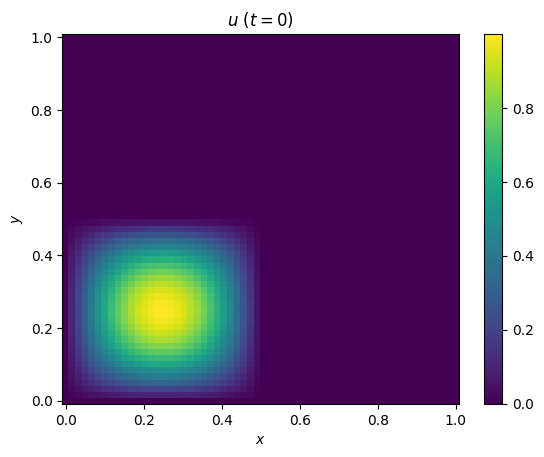

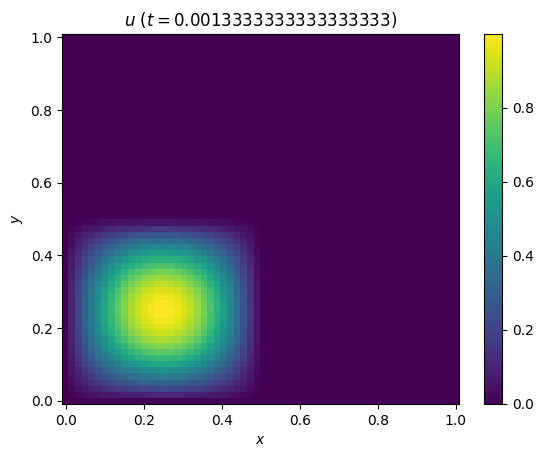

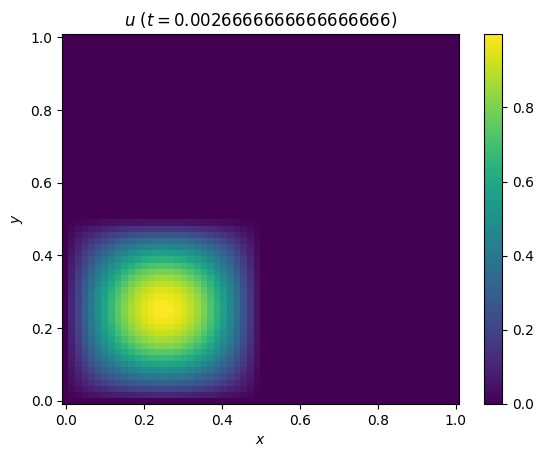

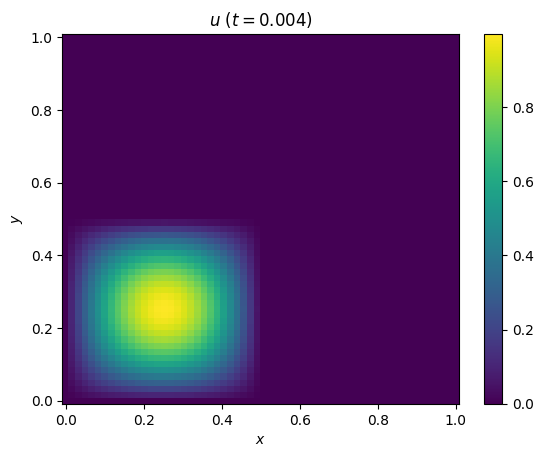

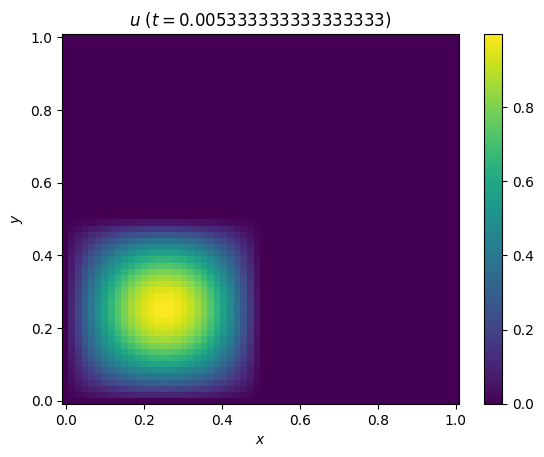

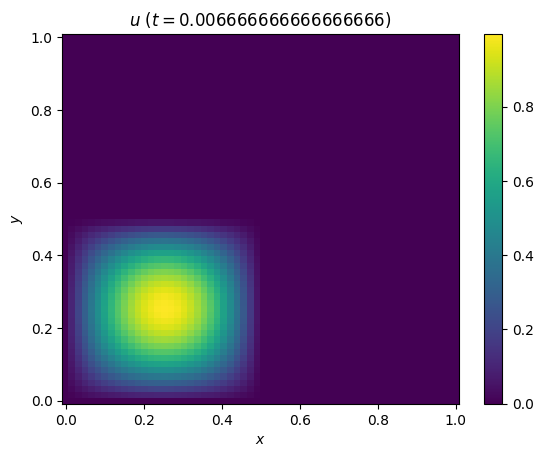

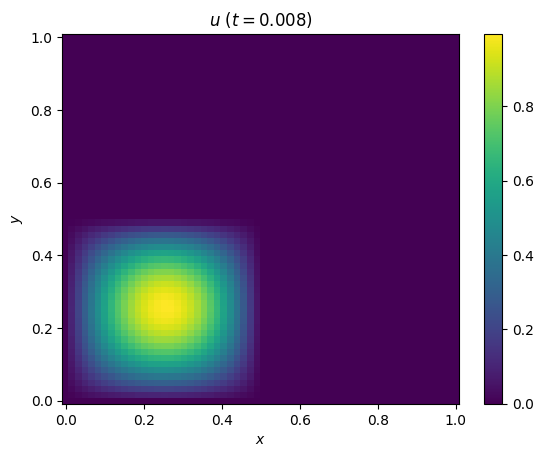

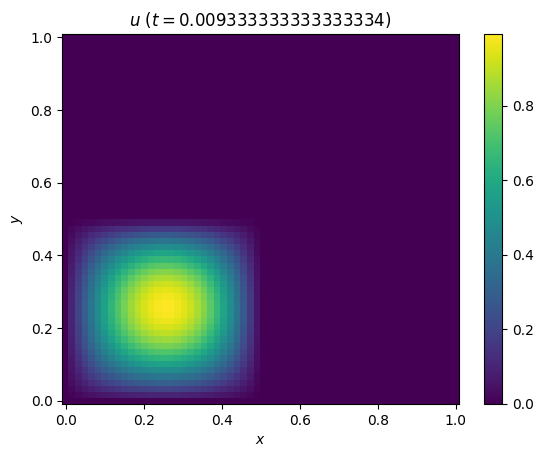

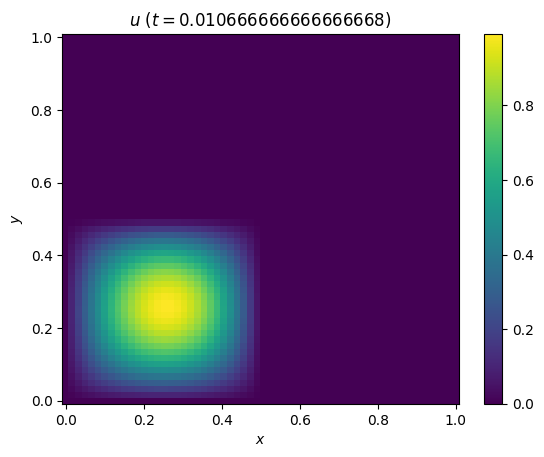

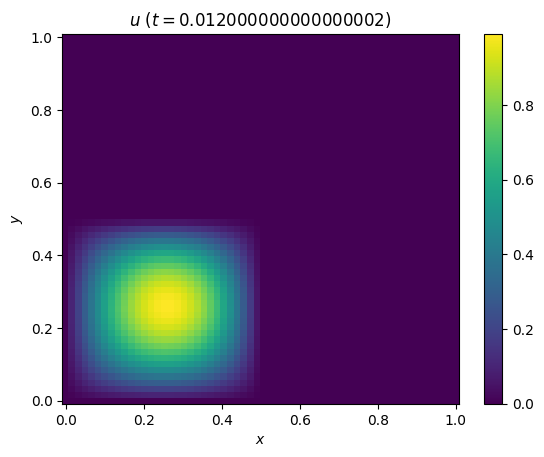

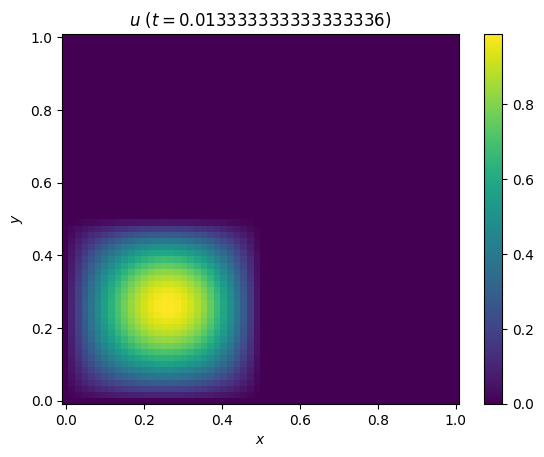

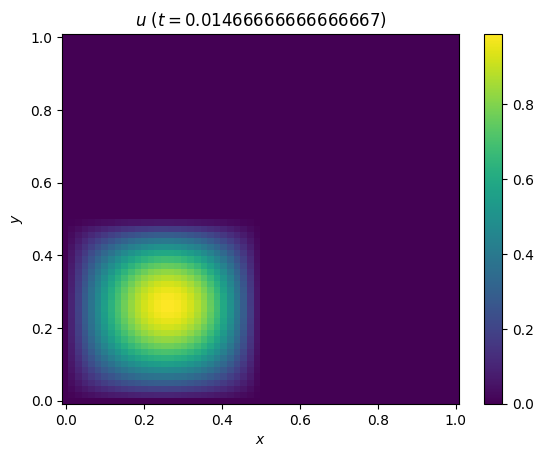

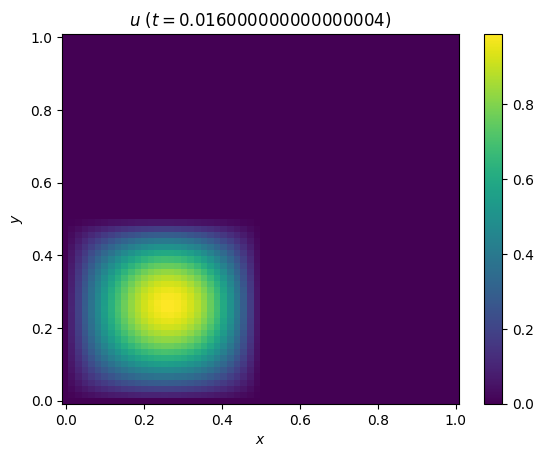

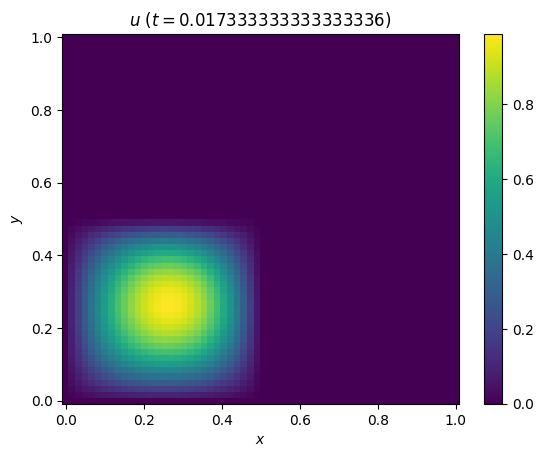

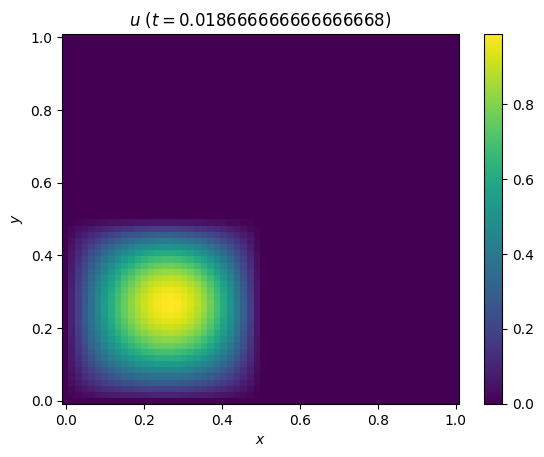

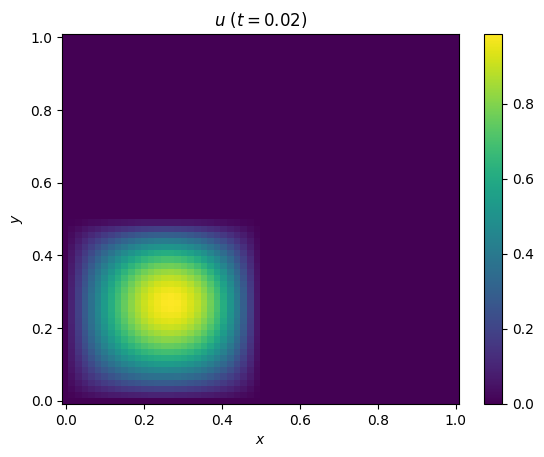

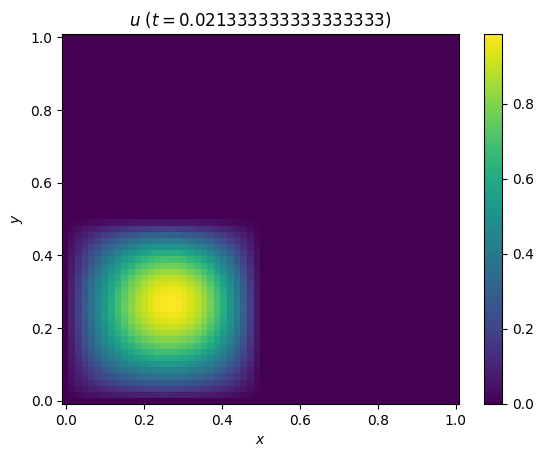

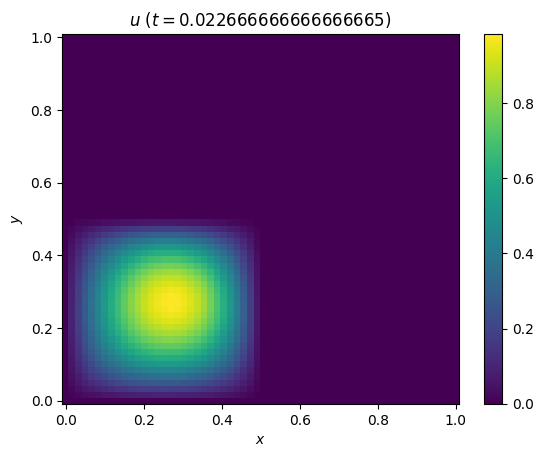

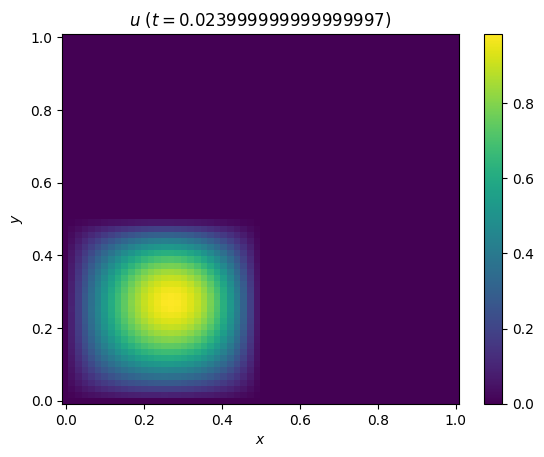

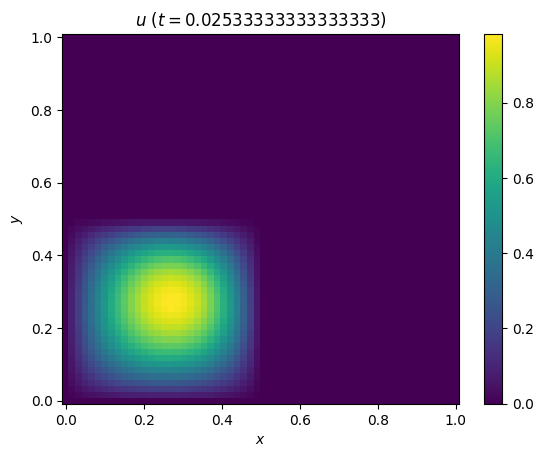

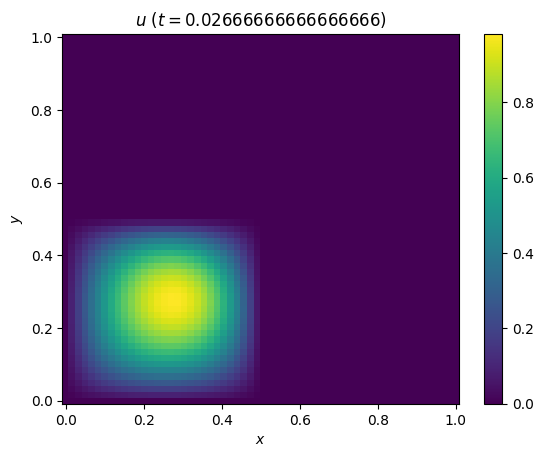

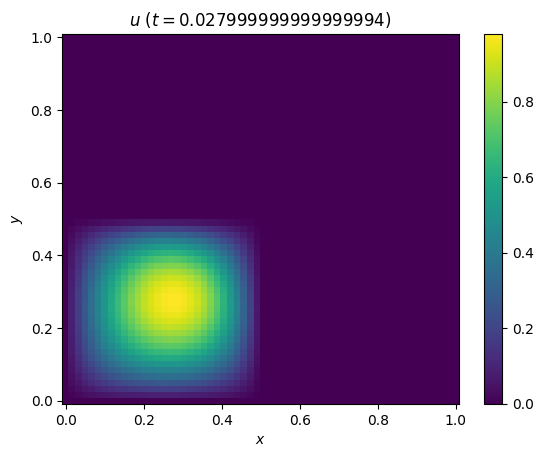

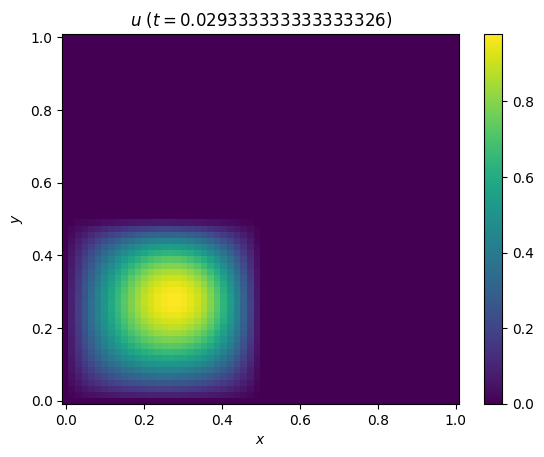

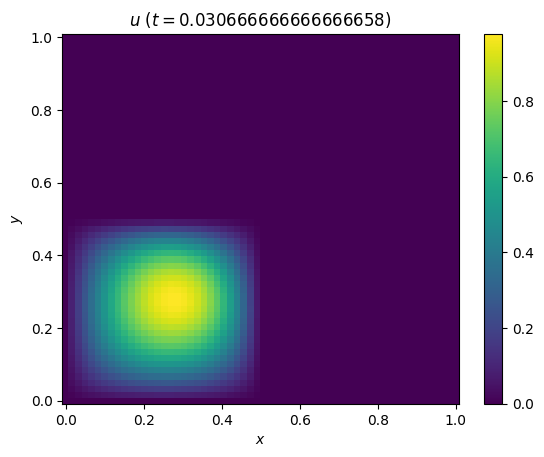

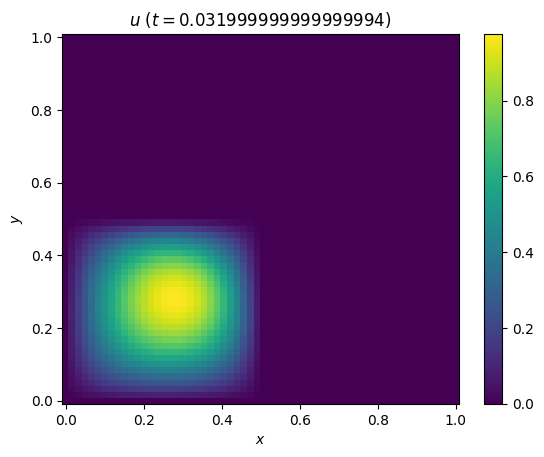

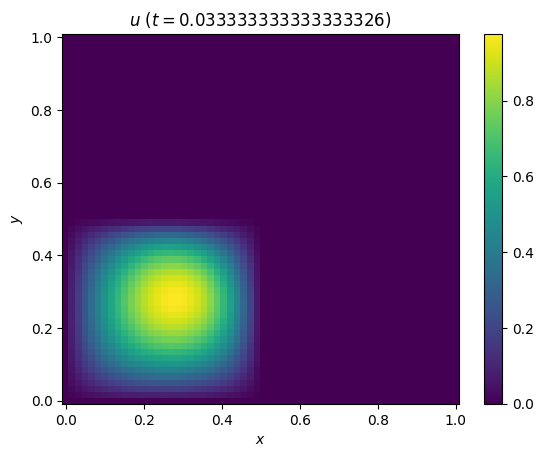

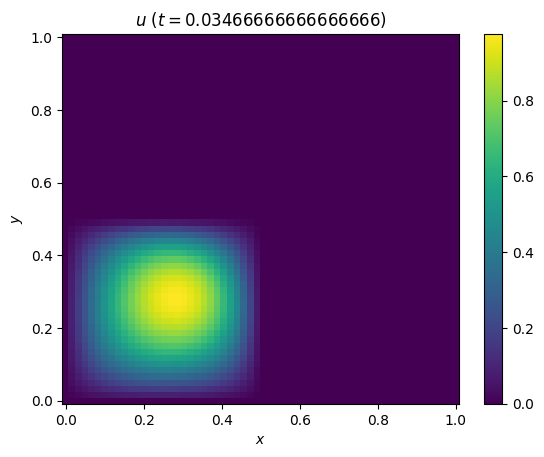

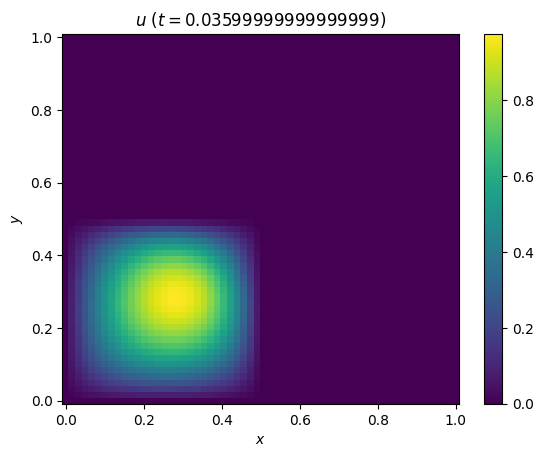

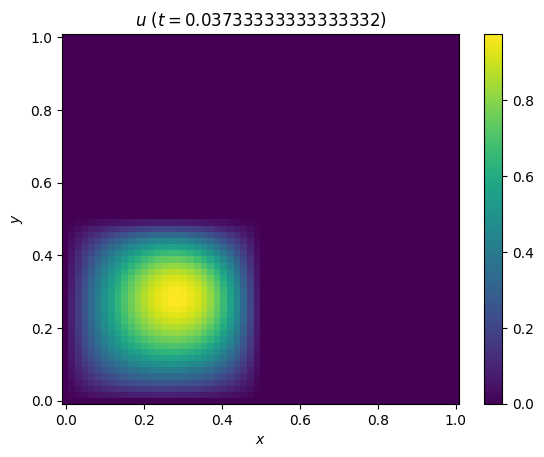

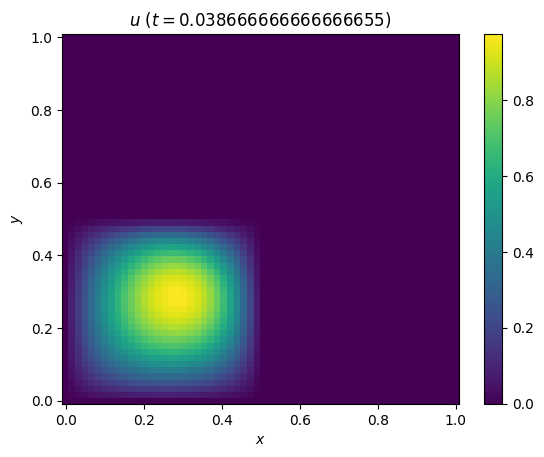

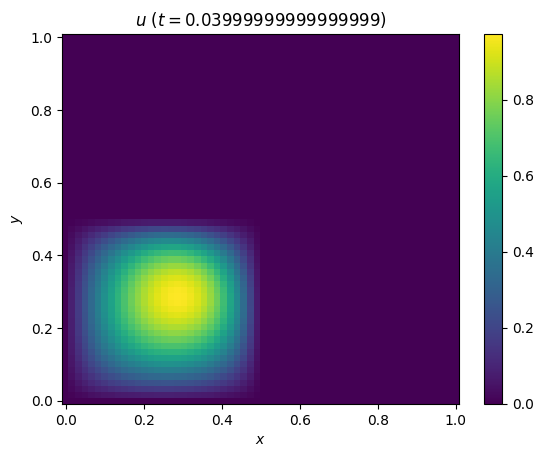

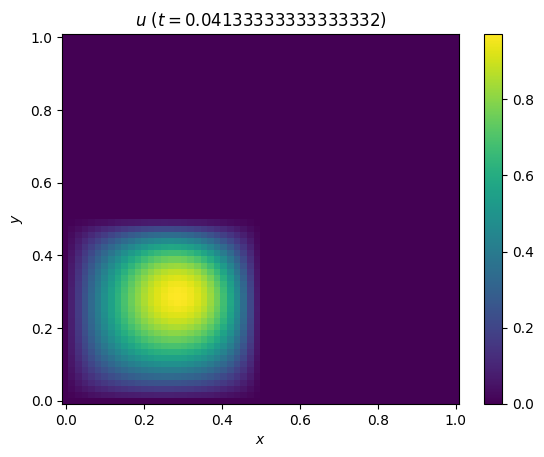

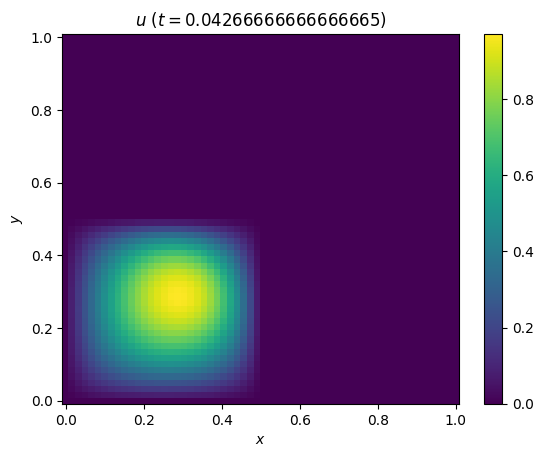

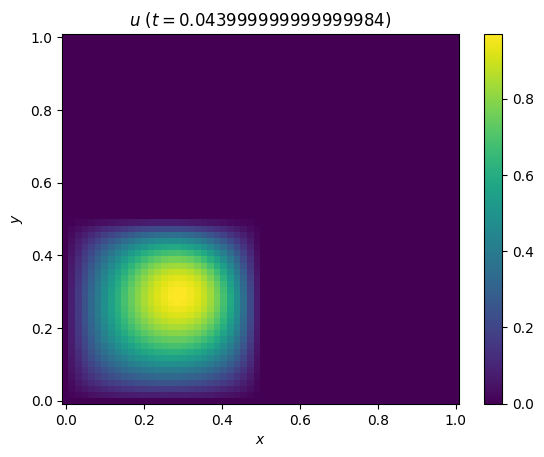

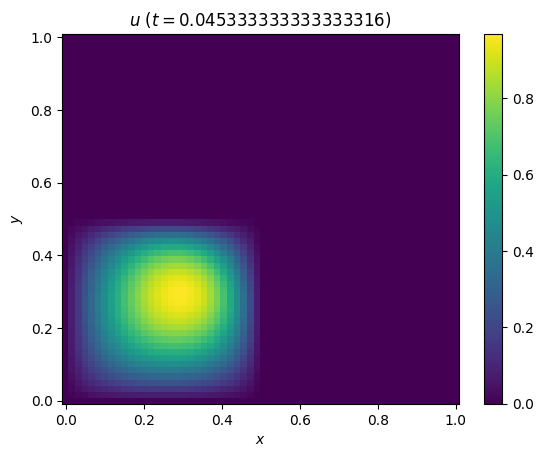

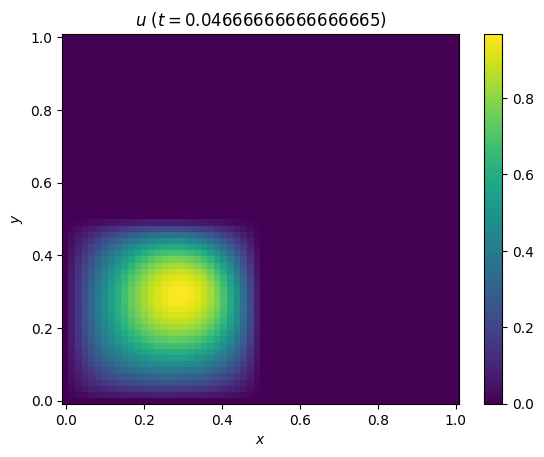

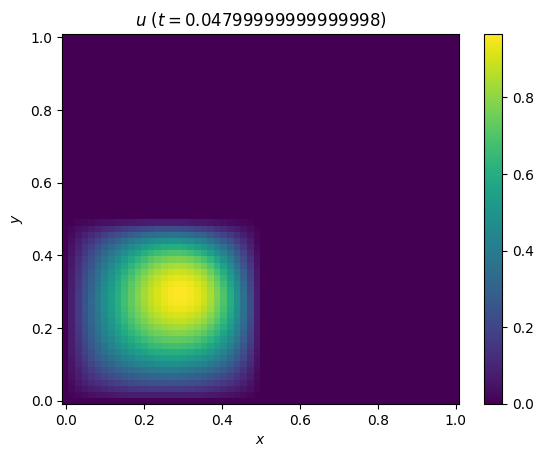

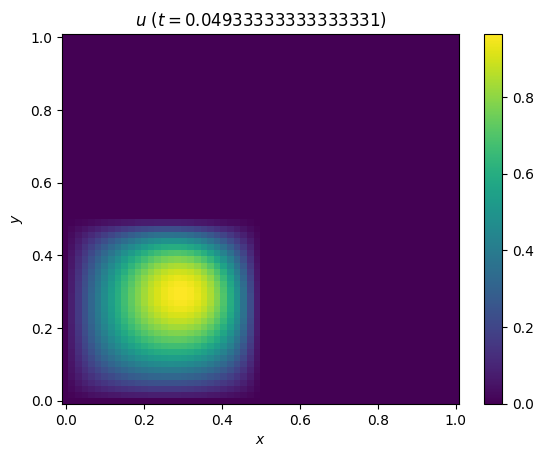

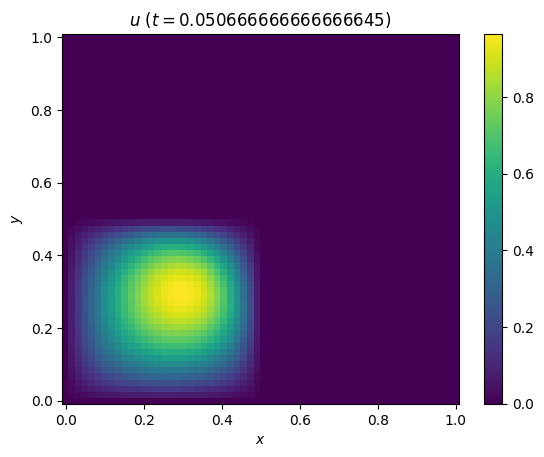

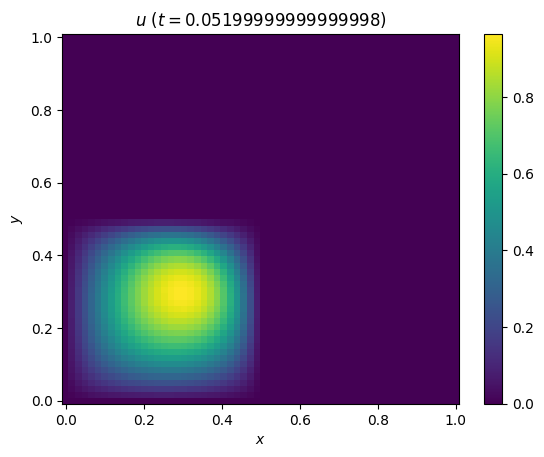

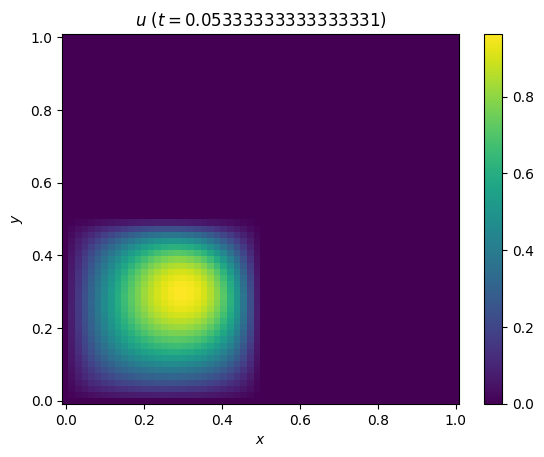

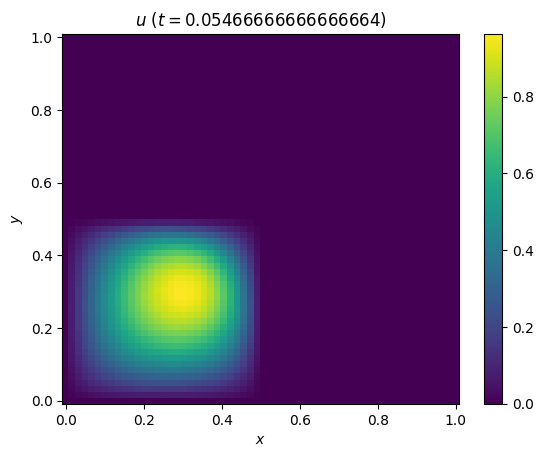

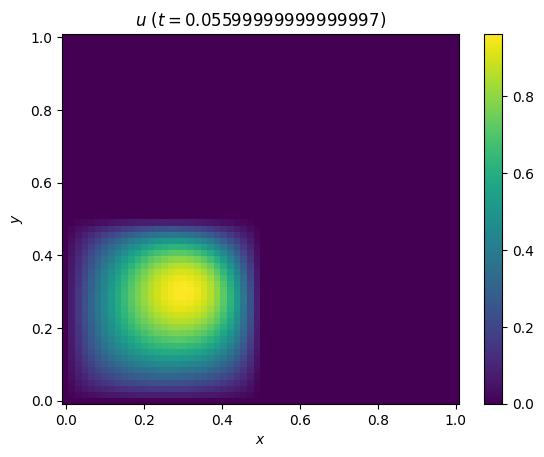

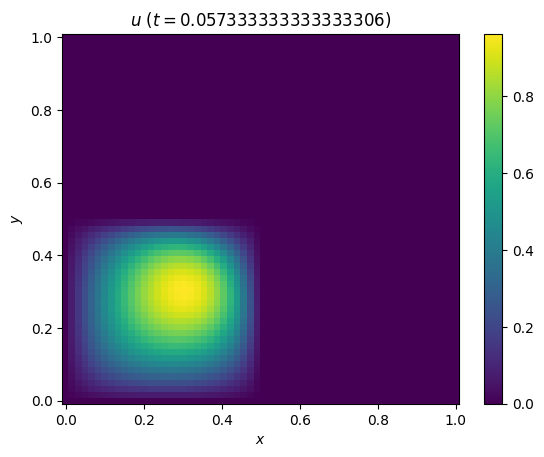

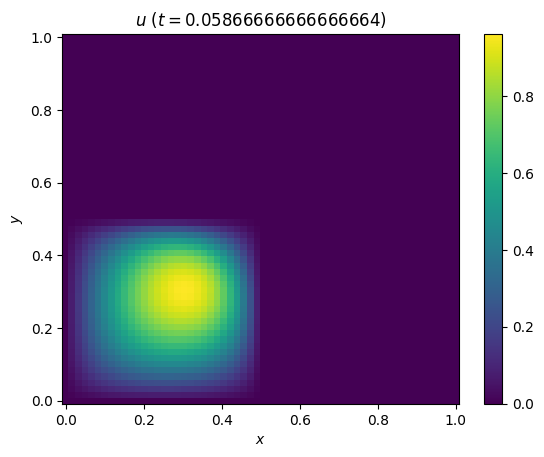

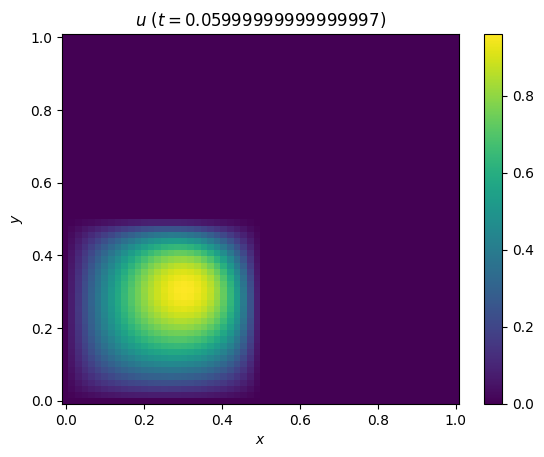

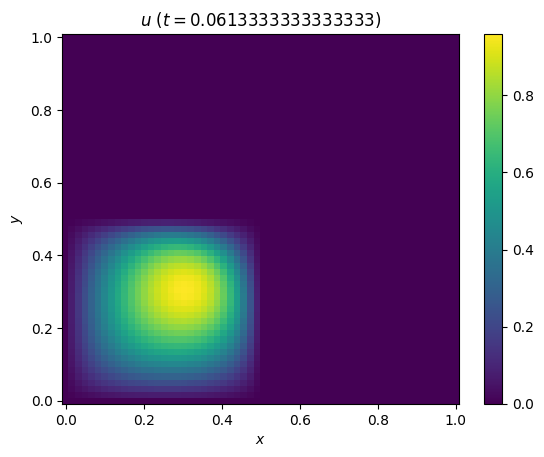

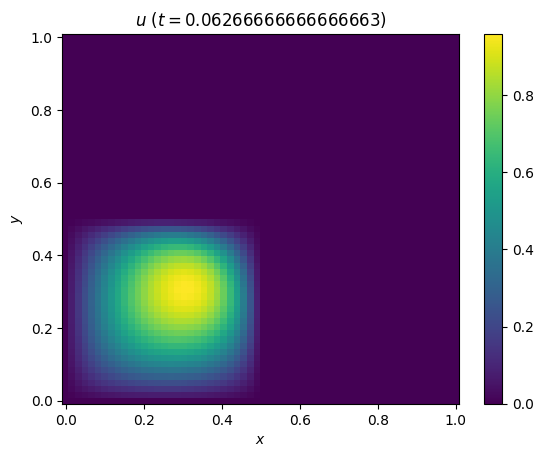

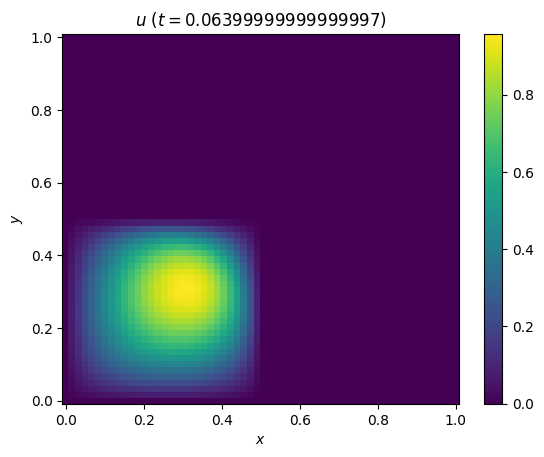

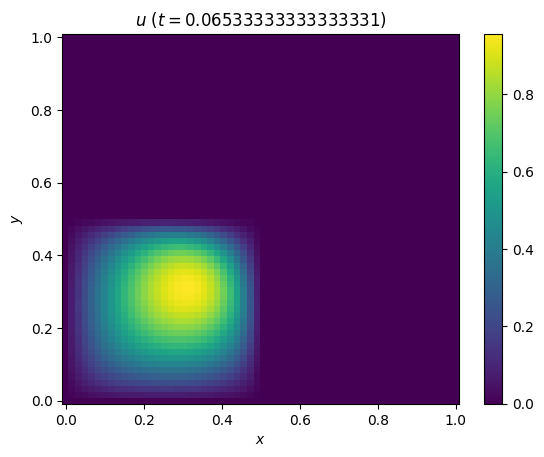

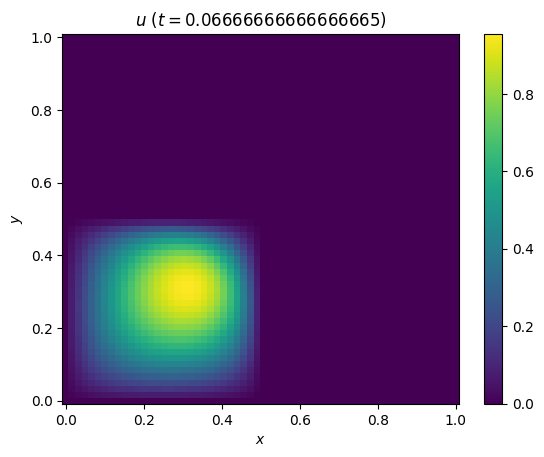

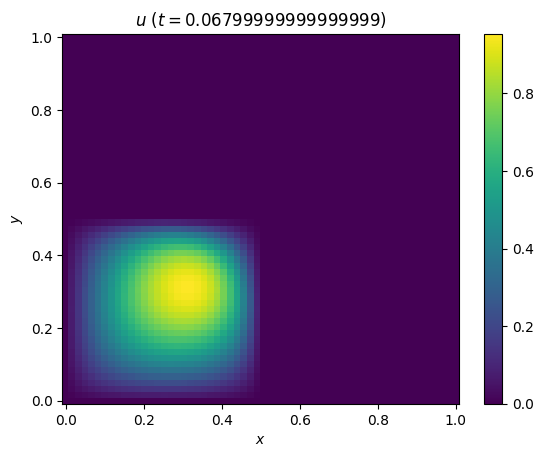

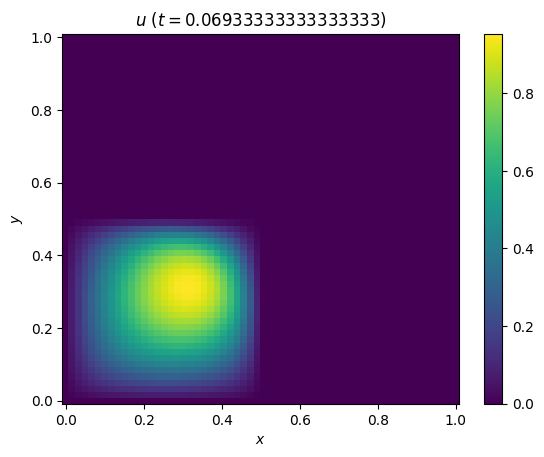

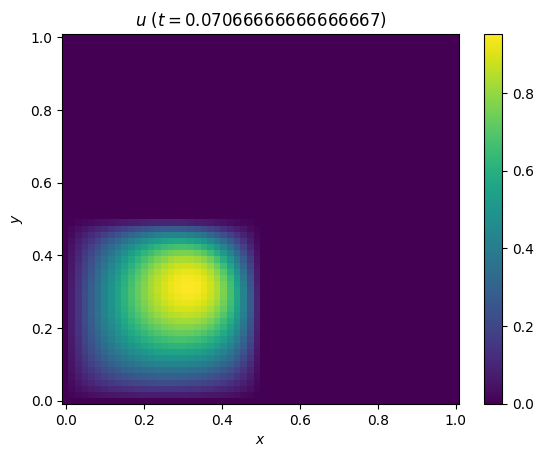

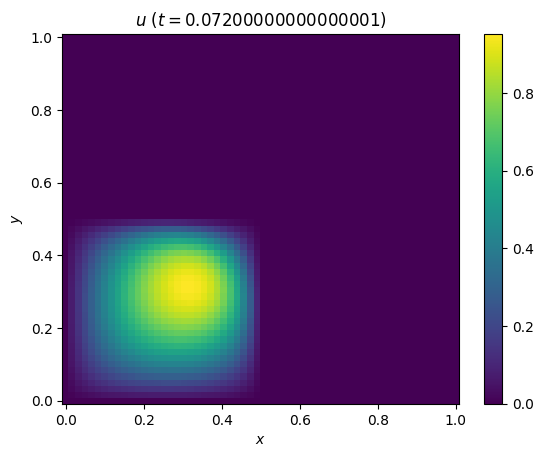

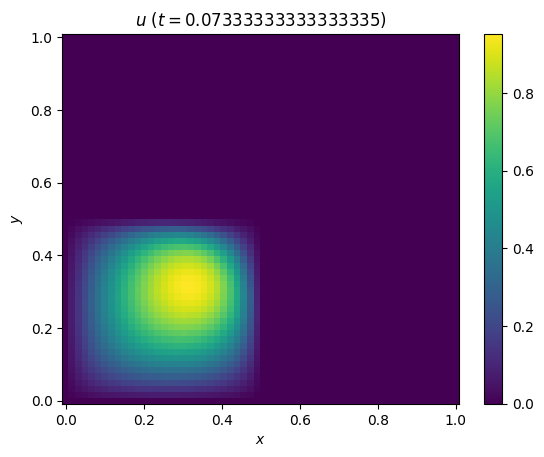

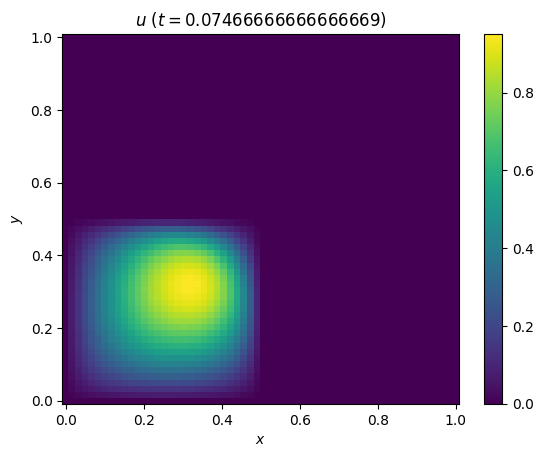

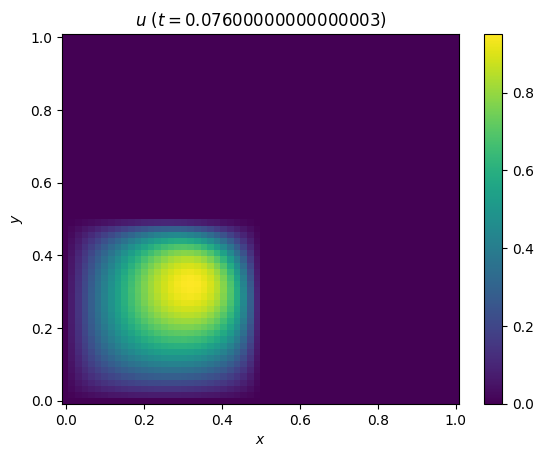

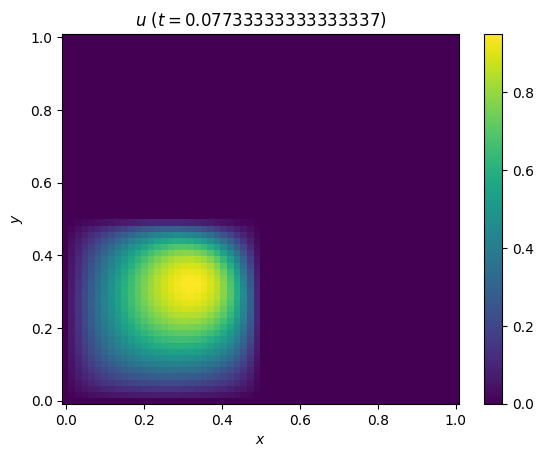

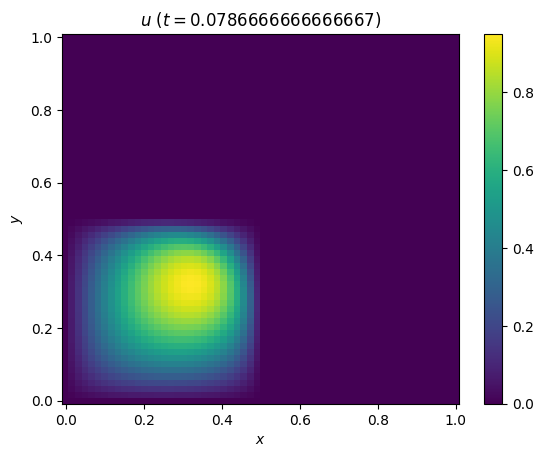

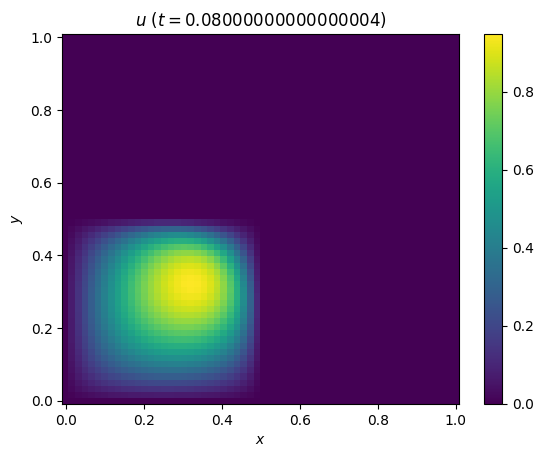

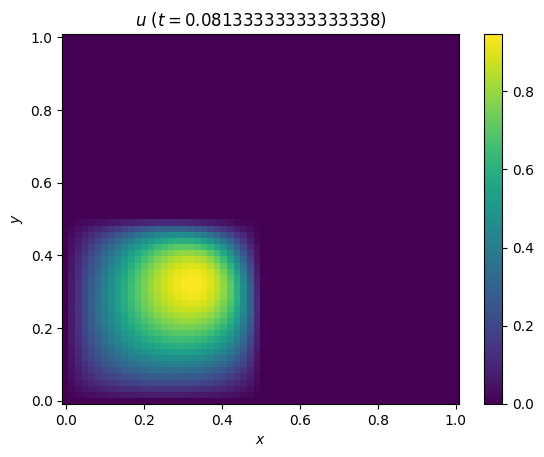

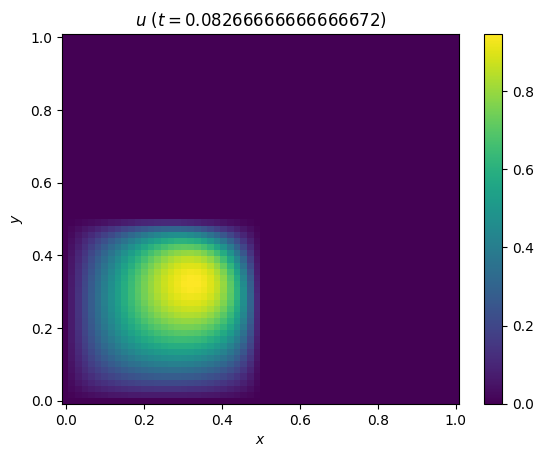

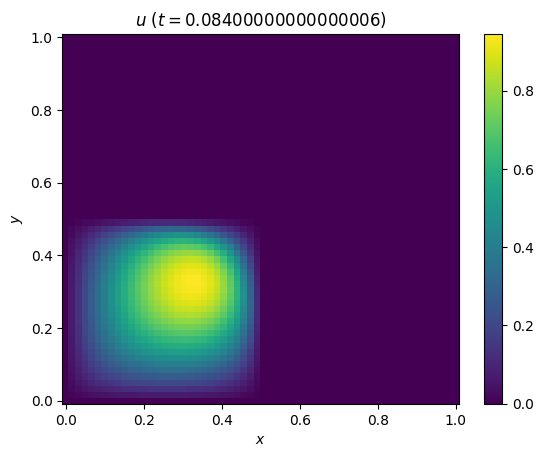

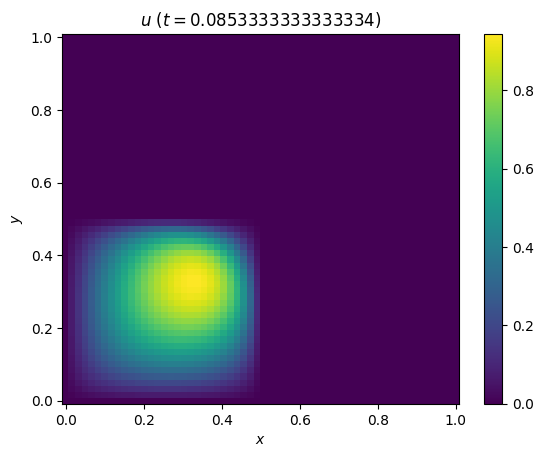

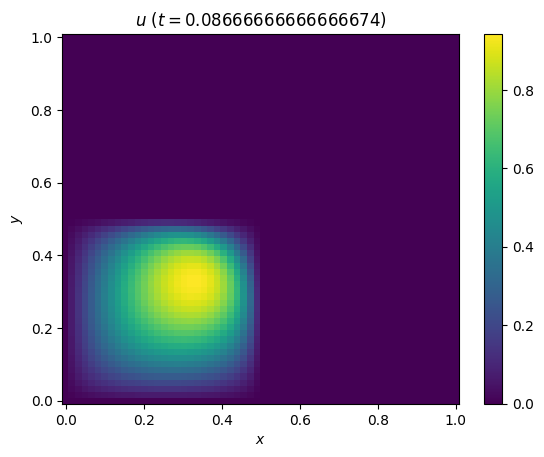

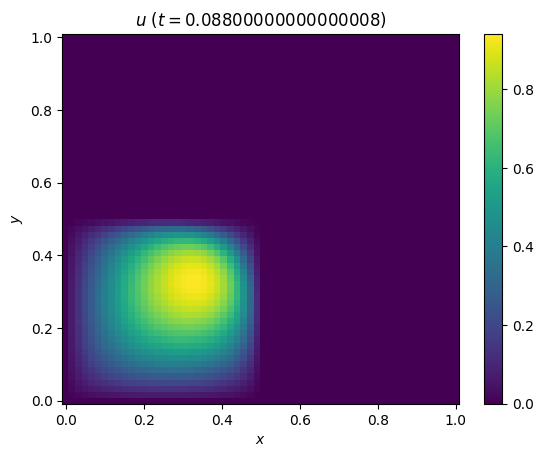

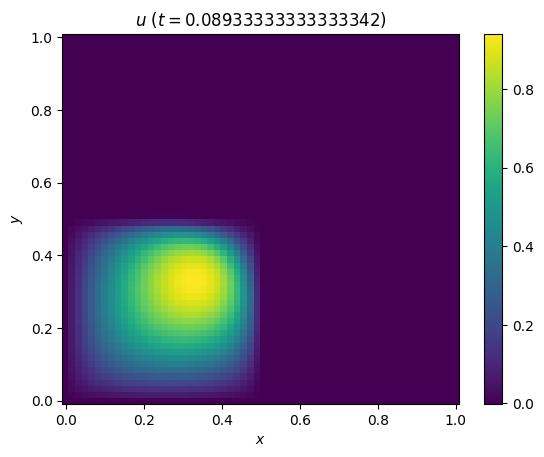

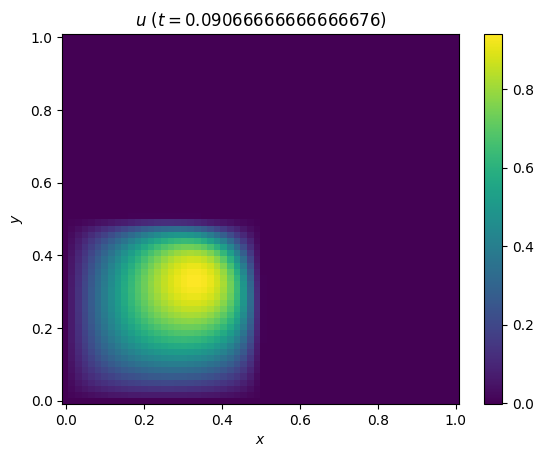

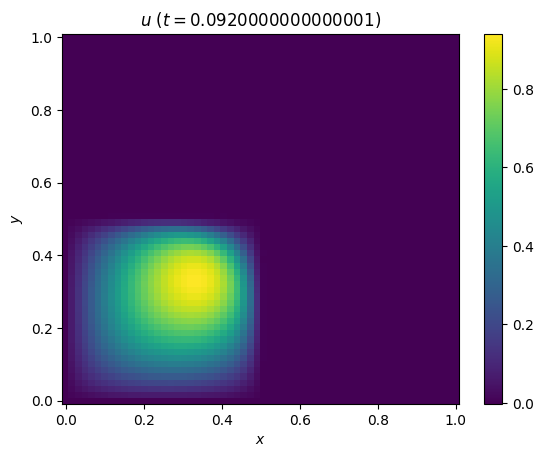

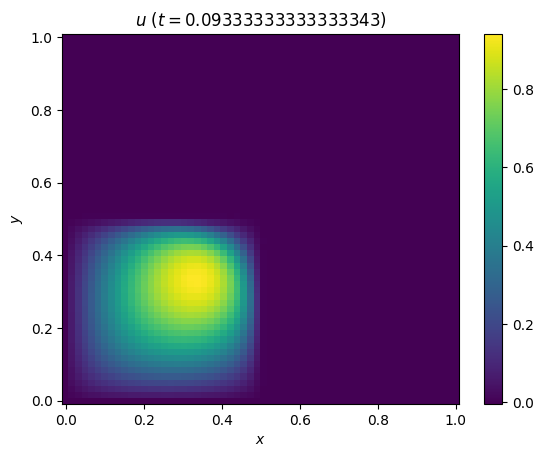

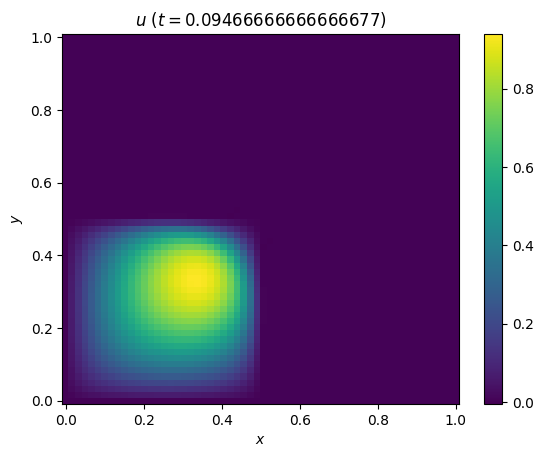

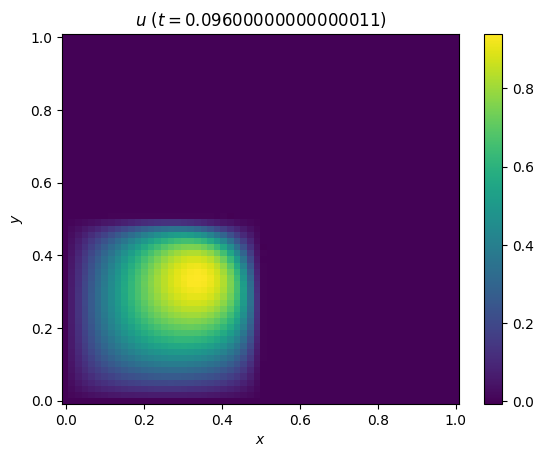

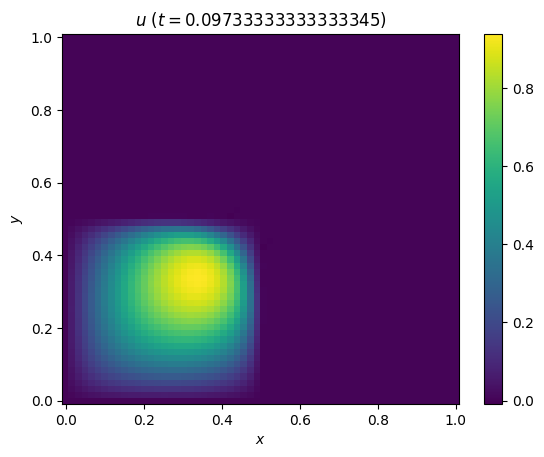

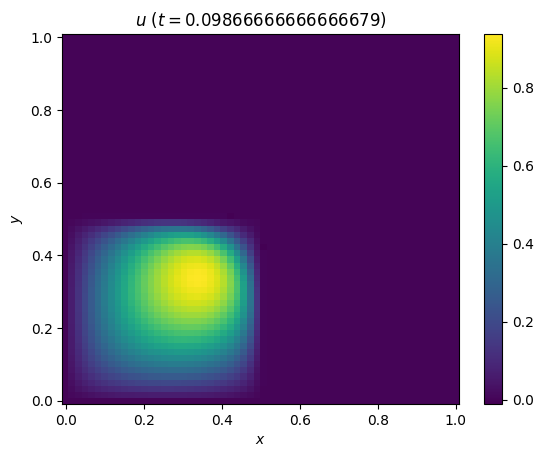

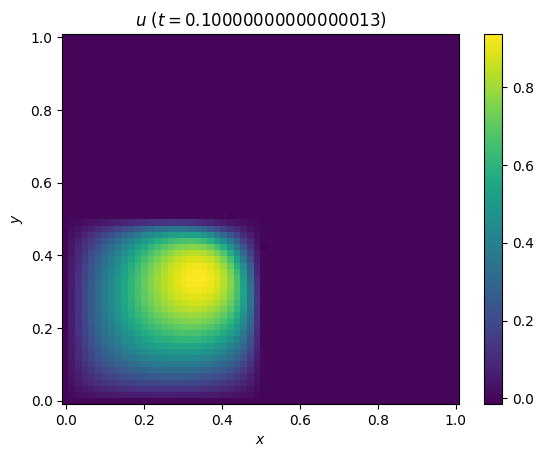

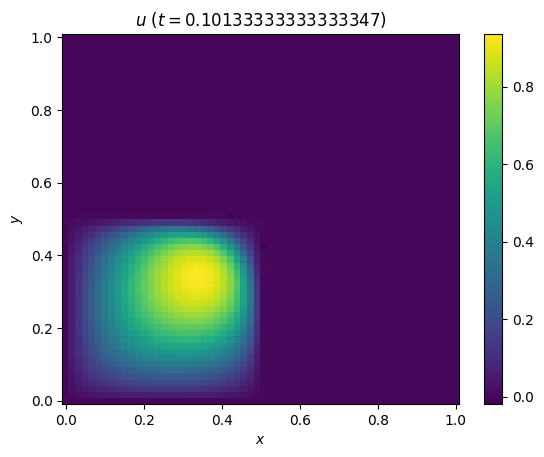

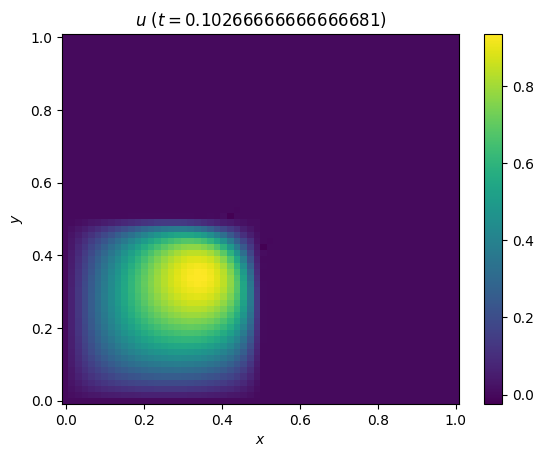

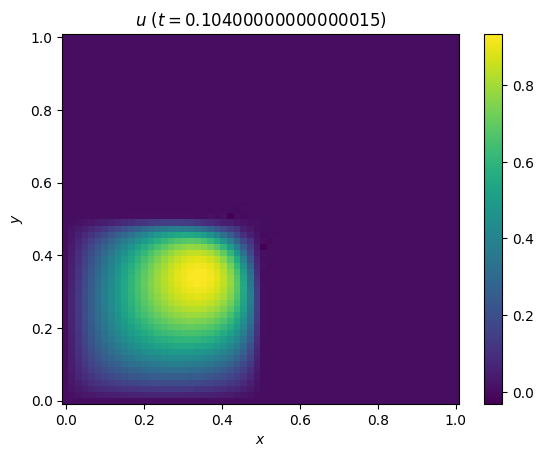

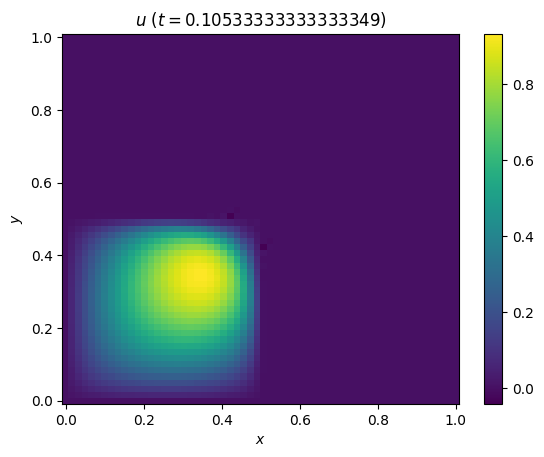

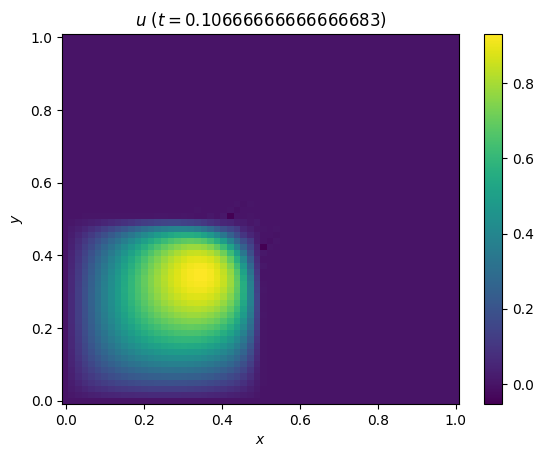

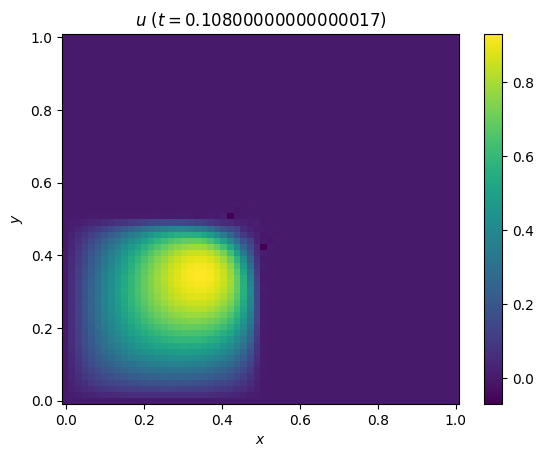

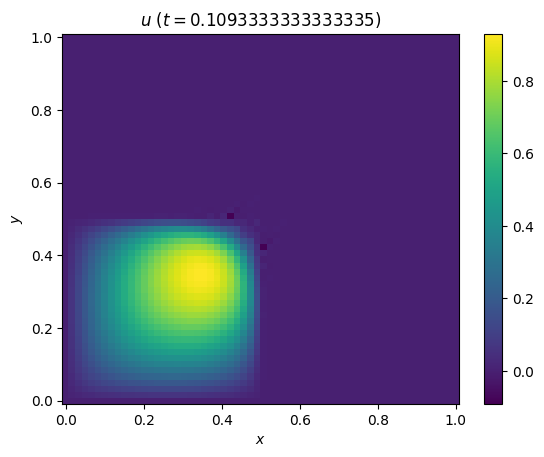

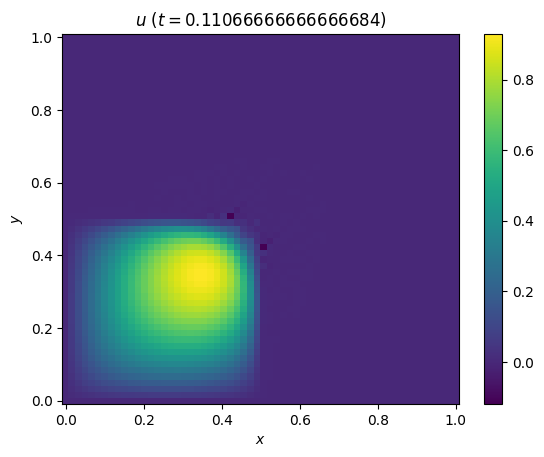

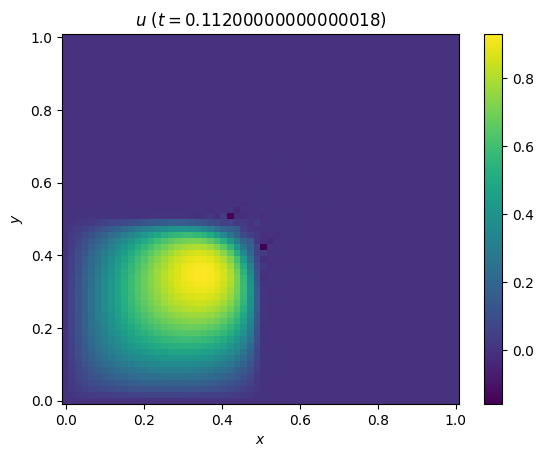

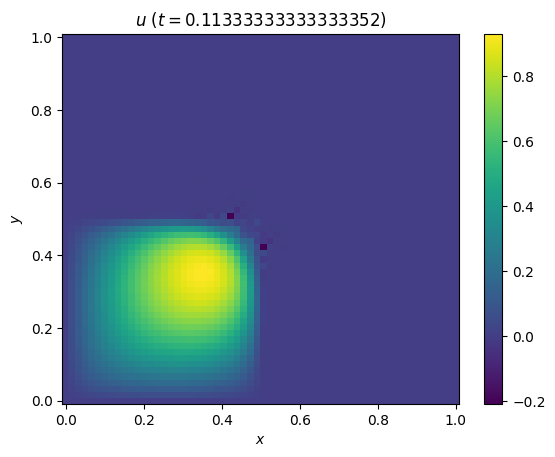

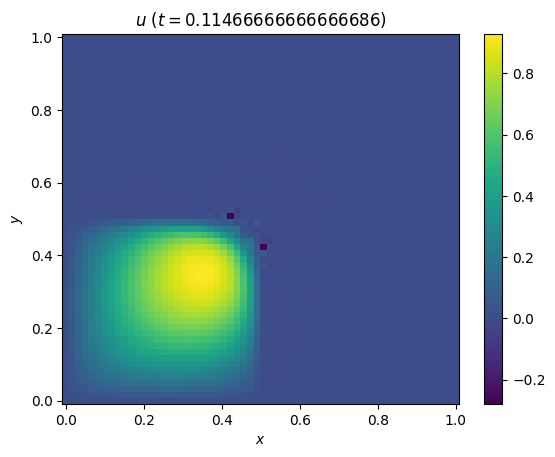

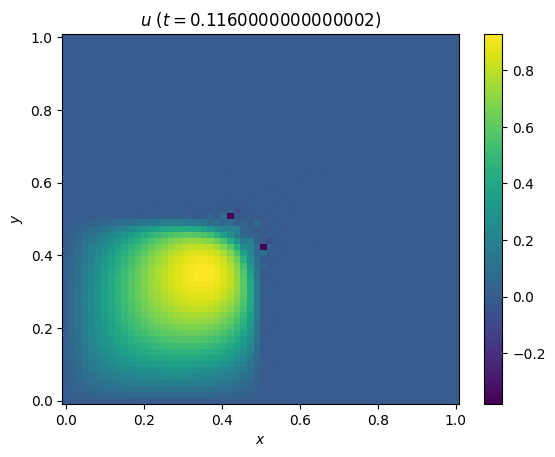

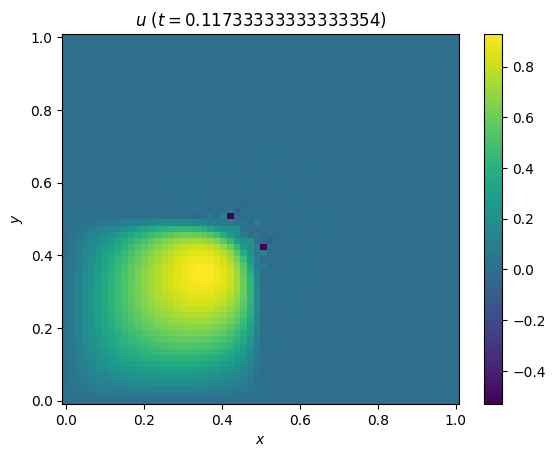

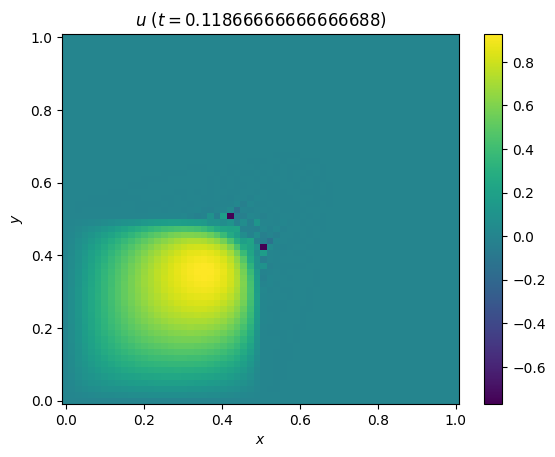

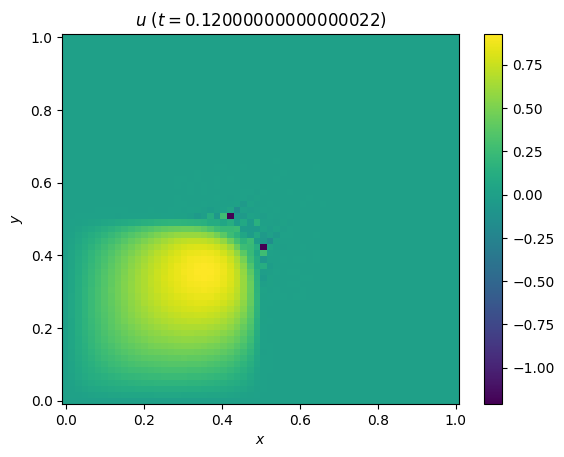

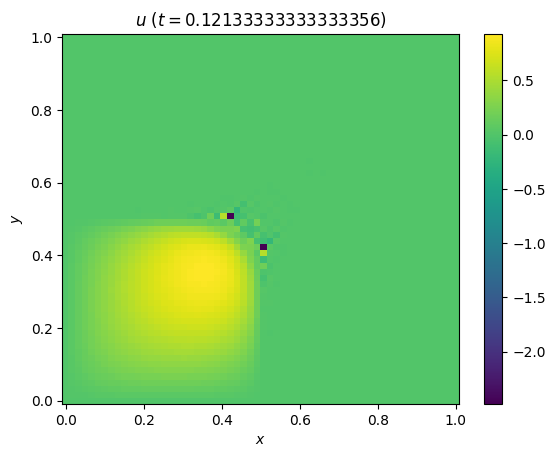

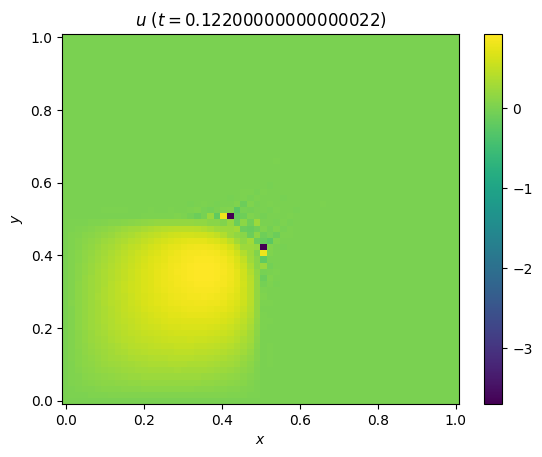

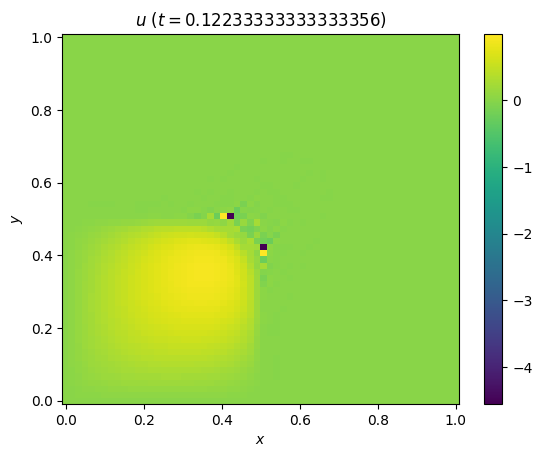

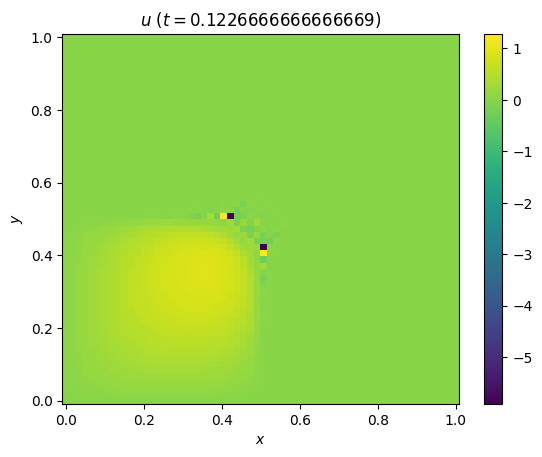

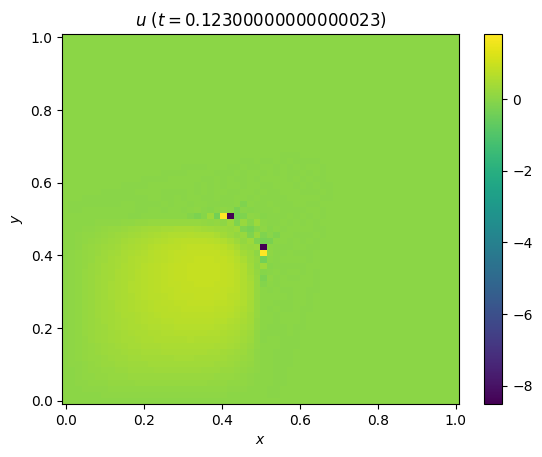

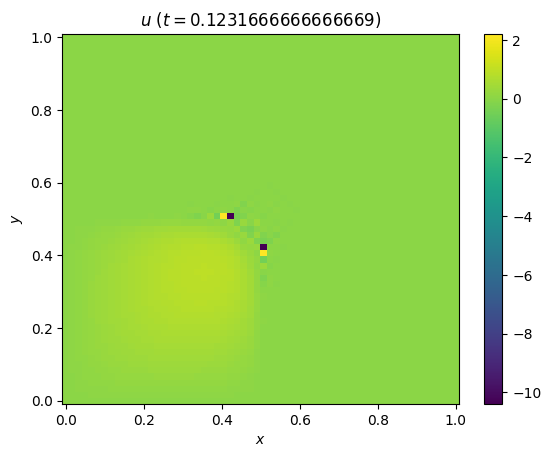

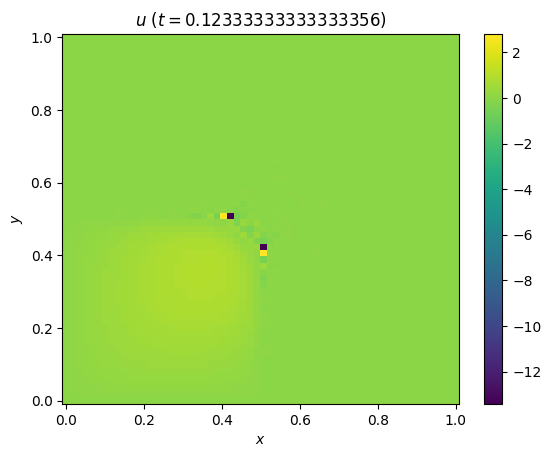

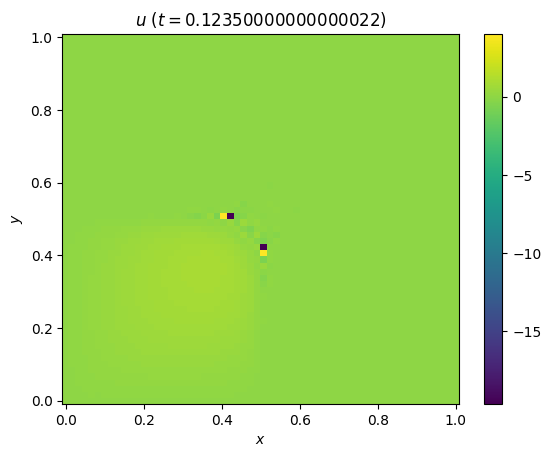

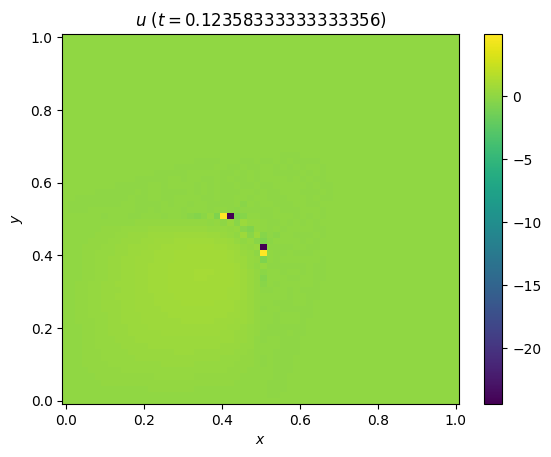

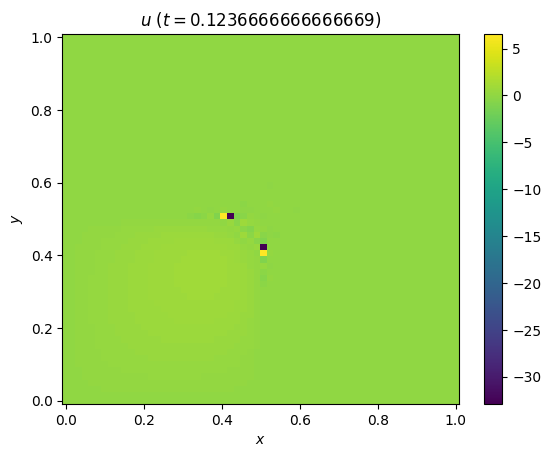

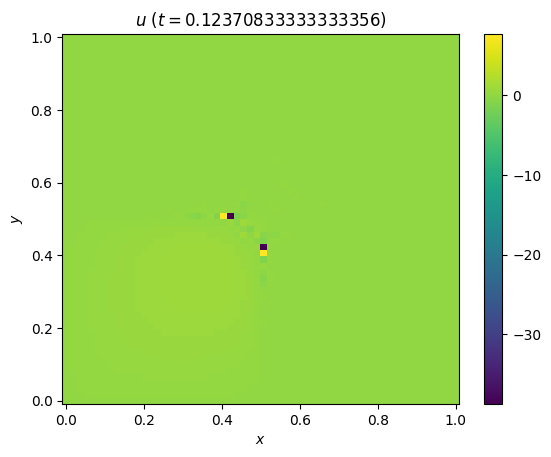

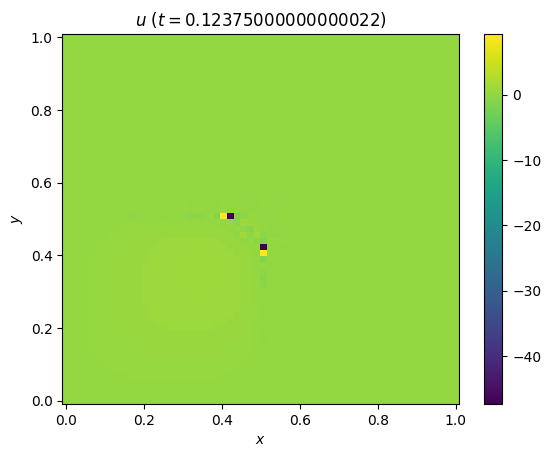

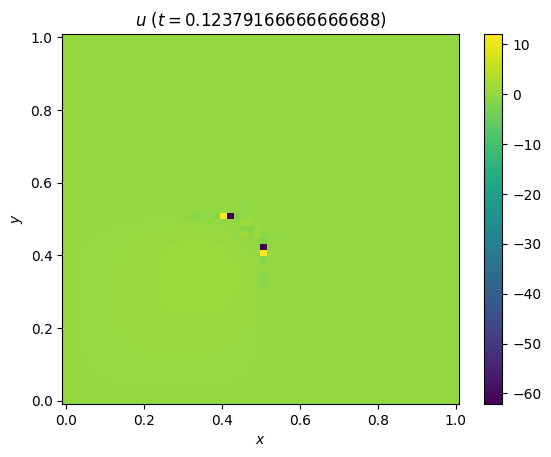

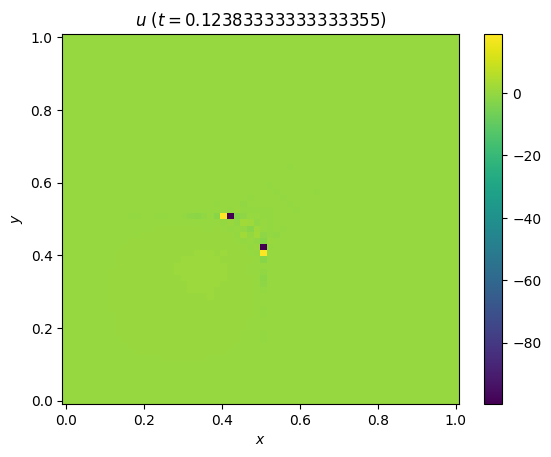

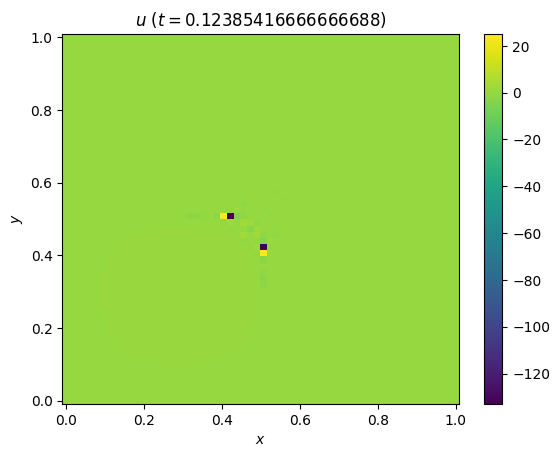

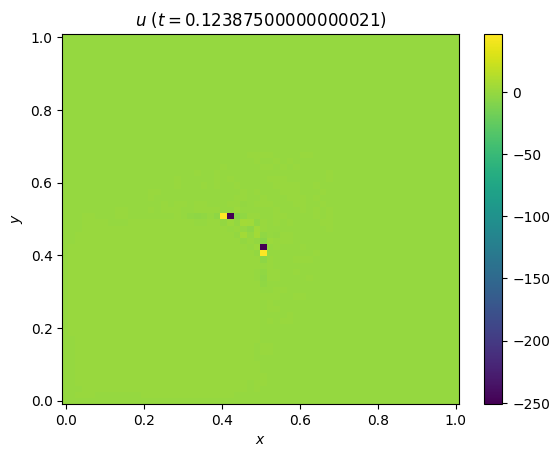

In [ ]:
# for t, x_red in sol.items():
#     approximate = np.matmul(basis, x_red)
#     # plot
#     ny = 60
#     nx = 60
#     x = np.load('paper_x.npy')
#     y = np.load('paper_y.npy')


#     fig_u = plt.figure()
#     ax_u = fig_u.gca()
#     p_u=ax_u.pcolor(x.reshape(ny,nx), y.reshape(ny,nx), (approximate).reshape(ny,nx))
#     cb_u=fig_u.colorbar(p_u,ax=ax_u)
#     ax_u.set_xlabel('$x$')
#     ax_u.set_ylabel('$y$')
#     plt.title('$u$ ($t = {:}$)'.format(t))
#     plt.show()